# Python code to perform principal components analysis (PCA) transform on a Sentinel-2A image of Queen Elizabeth Park in the Kapiti District

## GISC424 Lab 3 - Image interpretation - enhancements, transformations and indices

## Author: Andrew McMillan

### 31/3/2020

We will be runniing this tutorial using a conda environment. I have created a conda environment *.yml file called ea_environment.yml which can be found at https://github.com/ea-nz/GISC424_Lab_03/blob/master/ea_environment.yml.

The conda environment (called "ea") contains several of the packages required to do the core functions, data manipulation, plotting and transformations. It also contains the JupyterLab package that you will use to work through this Jupyter Notebook.


This tutorial aims to demonstrate the concept and practise of the Principal Component Analysis (PCA) transform in a way that would be difficult just using ENVI because of it's GUI "push-button" nature.

There is also a wider purpose to this tutorial — to take you beyond the GUI environment and into the script-based manipulation of imagery.  

We take an image that we have been working with in ENVI, read it into Python do some manipuations and some plotting. We then transform the image using PCA. We will plot the newly created PCA bands using the python plotting package matplotlib.

Finally, we will then export the PCA-transformed image back to a format that can be read by ENVI.

In this way, you will not only understand the significance of the PCA-transform, but also understand how you can take data from the ENVI environment, manipulate it using a programming language, and then bring it back into the ENVI environment. This is very useful to automate tedious operations and to provide "reproduceability".

While the Jupyter environment that we are using today is excellent for teaching concepts such as these, it becomes awkward when you want to operationalise something or do bulk-processing. So under those conditions, you probably want to use python-only scripts in a Integrated Development Environmnent, such as Spyder, PyCharm or VisualCode.







### Section 1. Starting up

Start off by loading the libraries

In [42]:
import os                              # a base python package for doing basic operations
import sys                             # a base python package for doing system-related operations
import numpy as np                     # numpy is a numeric python library 
import matplotlib.pyplot as plt        # the basic python plotting library
import rasterio as rio                 # a raster operation package - good for remote sensing data!
import pandas as pd                    # a data analysis library
import geopandas as gpd                # spatial data analysis (built on top of pandas)
import seaborn as sns                  # another graphing package - nicer graphs
import sklearn                         # a machine learning package

from pandas.plotting import scatter_matrix


### Section 2. Reading the Data and getting it into an array

load the raster (you will have to edit path)

In [43]:
#src = rio.open(r'D:\QE2\layers\Sentinel\S2A_Processed\Clip_Sent_to_ROI#2.dat')
#src = rio.open(r'D:\QE2\layers\Sentinel\S2A_Processed\QEP_sen2_clipped_to_ROI_2_10and20m_bands.dat')


# specify the folder and the file
work_folder = r'C:\Users\User\OneDrive - Victoria University of Wellington - STUDENT\Remote Sensing (GISC424 )\LAB_3\Lab3_data\Lab3_data'
sentinel_image_filename = 'sent_2a_image_corr_QEP_segment.dat'

#join these together to get the full path
ffin = os.path.join(work_folder, sentinel_image_filename)

#make sure the path exists
os.path.exists(ffin)

#open the file with rasterio. We read the information from this file into an "object" called "src"
src = rio.open(ffin)
# print("src :",src)

in Python "Objects" often have "methods", which are things you can do to that object. 
They also have attributes, things that are associated with them.
since src is an object containing spatial information, you would expect it to have information about datum, precision etc)
That information is stored in the attribute "profile"

you can access that information, generically by typeing: object_name.attribute,
or in this specific case: src.profile

In [44]:
src.profile

{'driver': 'ENVI', 'dtype': 'uint16', 'nodata': 0.0, 'width': 190, 'height': 140, 'count': 10, 'crs': CRS.from_epsg(32760), 'transform': Affine(10.0, -0.0, 328980.0,
       -0.0, -10.0, 5465380.0), 'tiled': False, 'interleave': 'band'}

Objects also have methods (also known as functions) - things you can do with them. They can be accessed in the same way but often have parenthesis, indicating that you can provide some parameters. But sometimes you don't need to and you can just use empty parentheses. eg src.read() will read the raster data stored in the object and give an array, arr

In [45]:
# read the opened file into an array
arr = src.read()

check the array dimensions

In [46]:
arr.shape

nbands = arr.shape[0]
nrows = arr.shape[1]
ncols = arr.shape[2]

In [47]:
arr.shape

(10, 140, 190)

We can see that the array as read from the raster is in the shape p x m x n (where p = bands, m = rows and n = columns)
When we do PCA we are not interested in rows and columns so reshape the array so that it is 2 dimensional , q x p , where the length of q is m x n.

In [48]:
arr_2d = np.transpose(np.reshape(arr, (nbands, nrows*ncols)))
arr_2d.shape

(26600, 10)

### Section 3. Scaling the data and saving data to text files

The PCA transform is scale-dependent, so that the actual values of the bands have an effect on the outcome of the transform. We are not interested in these scale effects so we normalise the data to Z values (Z = (xi - mean(X))/(stddev(x))

In [49]:
from sklearn.preprocessing import StandardScaler
arr_2d_scaled = StandardScaler().fit_transform(arr_2d)

Do an interim save of the scaled and unscaled data

In [50]:

arr_2d_unscaled_df = pd.DataFrame(arr_2d)
arr_2d_df = pd.DataFrame(arr_2d_scaled)

arr_2d_df.to_csv(r'C:\Users\User\OneDrive - Victoria University of Wellington - STUDENT\Remote Sensing (GISC424 )\LAB_3\Lab3_data\Lab3_data\orig_data_scaled.csv')
arr_2d_unscaled_df.to_csv(r'C:\Users\User\OneDrive - Victoria University of Wellington - STUDENT\Remote Sensing (GISC424 )\LAB_3\Lab3_data\Lab3_data\orig_data.csv')

sns.set(style = 'ticks')

### Section 4. Plotting the data using the Seaborn package

Do a scatter plot in matrix form of all each band against each other band (takes a few moments)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025FC34AC1C8>,
      dtype=object)

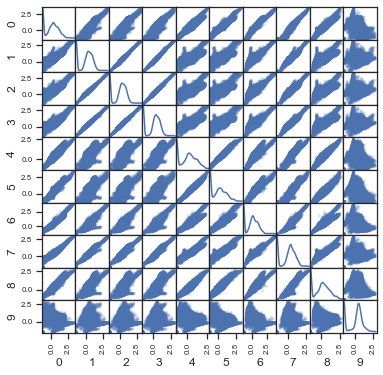

In [51]:


scatter_matrix(arr_2d_df, alpha = 0.2, figsize = (6, 6), diagonal = 'kde')


In the above figure you can see that many of the bands are highly correlated with each other. Note that python starts counting from Zero, so that the indices of this plot are 1 less than the actual band number, ie Band 0 in the figure refers to band 1 from the image.

### Section 5. Perform a Principal Component Analysis Transform using the sckikit-learn package

Do a principal component analysis of the 10 orginal sentinel bands. We will reduce dimensionality by only retaining 5 principal components.

In [52]:
# load the PCA module from the sklearn (scikit-learn) package 
from sklearn.decomposition import PCA 

# Initialise a pca object choosing to reduce dimensions to just 5 (from the original 10)
pca = PCA(n_components=5)

# Do a PCA transform by invoking the "fit_transform" method on the pca object
principal_components = pca.fit_transform(arr_2d_df)

# Look at the shape of the output
principal_components.shape

(26600, 5)

now make a scatterplot of the PCA-transformed data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F98F08E88>,
      dtype=object)

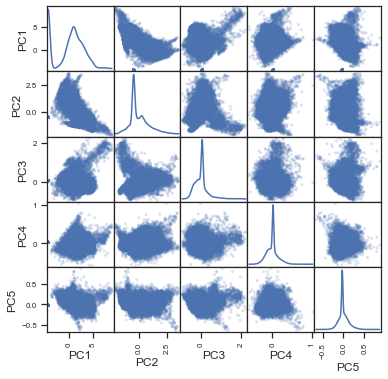

In [53]:
principal_components_df = pd.DataFrame(data = principal_components, columns = ['PC1','PC2','PC3','PC4','PC5'])
principal_components_df.to_csv(r'C:\Users\User\OneDrive - Victoria University of Wellington - STUDENT\Remote Sensing (GISC424 )\LAB_3\Lab3_data\Lab3_data\trfmd_data.csv')
scatter_matrix(principal_components_df, alpha = 0.2, figsize = (6, 6), diagonal = 'kde')

Now you can see that the bands exhibit much less correlation between each other

What is the amount of variance in the image that is explained by each of the newly transformed bands?

In [54]:
print(pca.explained_variance_ratio_)


[0.91451412 0.06861646 0.01227393 0.00195602 0.00130545]


For those of you who have dealt with eigenvalues and eigenvectors, the above values are the normalised eigenvalues. The values indicate the proportion of variance explained by each principal component, ie, PC1 explains 91% of the total variance in the imagery, PC2 explains 6% of the variance in the imagery, PC3 explains 1.2% of the variance, etc

Now look at the components (these would be the Eigenvectors). In terms of this remote sensing application, these can be interpreted as the linear coefficients (or weightings) that we apply to each band to do the PCA-transform.

In [55]:
pcomps = pca.components_

Put these into a Pandas data frame

In [56]:
pcomps_df = pd.DataFrame(pcomps)

Save the principal components to a file

In [57]:
pcomps_df.to_csv(r'C:\Users\User\OneDrive - Victoria University of Wellington - STUDENT\Remote Sensing (GISC424 )\LAB_3\Lab3_data\pcomps_df.csv')

Plot the principal components to see which bands have the most weighting for each component

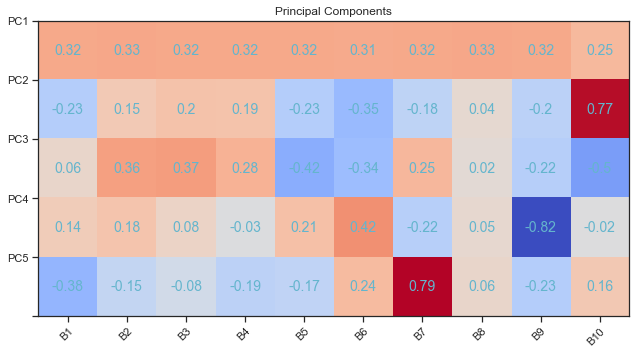

In [58]:
# plt.imshow(pcomps, cmap = "coolwarm")
# plt.colorbar()

bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10"]
components = ["PC1","PC2","PC3","PC4","PC5"]



fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(pcomps,cmap = "coolwarm")


# We want to show all ticks...
ax.set_xticks(np.arange(len(bands)))
ax.set_yticks(np.arange(-.5,5.5))
# ... and label them with the respective list entries
ax.set_xticklabels(bands)
ax.set_yticklabels(components)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations.
for i in range(len(components)):
    for j in range(len(bands)):
        text = ax.text(j, i, np.round(pcomps[i, j],2),
                       ha="center", va="center", color="c", size = 14)

im.colorbar
        
ax.set_title("Principal Components")
fig.tight_layout()
plt.show()

From the above, it is evident that the first component (which contains 90% of the information) has about equal weightings on each band. Then if we look at PC2 there is a lot of weight on B10 and quite a bit also on B6.In the above, remember that highly negative values are just as important as highly positive values


What do these principal components mean? Well these are the numbers that are used to transform Bands 1 to Band 11 of the original data to the 5 new bands: Principal Components 1 to 5.

The transformed array will have the same number of rows and columns but fewer bands (only 5 in this case)

To get the first PC band for each pixel you would take the value for each of the 10 bands and multiply them by the corresponding PC Coefficient.

eg

PC1 = (0.32 × B1) + (0.33 × B2) + (0.32 × B3) +  ... + (0.25 × B10)
PC2 = (-0.23 × B1) + (0.15 × B2) + (0.20 × B3) +  ... + (0.77 × B10)





In the above, remember that highly negative values are just as important as highly positive values

In [59]:
principal_components.shape

(26600, 5)

Now take the dataframe data (a q x p array) and put it back into into a m x n x p form

In [60]:

PCA_mat = np.reshape(principal_components, (nrows, ncols, principal_components.shape[1]))

PCA_mat.shape

(140, 190, 5)

### Section 6. Learning How to Plot an Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


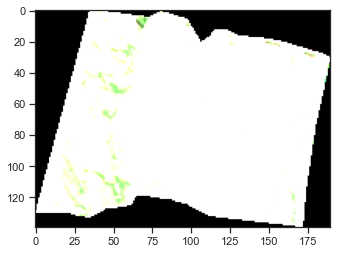

In [61]:
rgb_bands_orig = arr[8:5:-1,:,:]
rgb_bands_orig_sh = np.moveaxis(rgb_bands_orig,0,-1)

rgb_bands_orig.shape
plt.imshow(rgb_bands_orig_sh)
# rgb_bands_orig.shape

Matplotlib's RGB plotting cant deal with floats unless they are between 0 and 1. So lets normalise the whole array

Find the maximum value across the whole RGB image

In [62]:
rgb_bands_orig_norm_max = np.max(rgb_bands_orig_sh)

Divide every pixel by this value

In [63]:
rgb_bands_orig_norm = rgb_bands_orig_sh/rgb_bands_orig_norm_max

Check to make sure the shape looks ok

In [64]:
rgb_bands_orig_norm.shape

(140, 190, 3)

Now plot the normailised RGB array

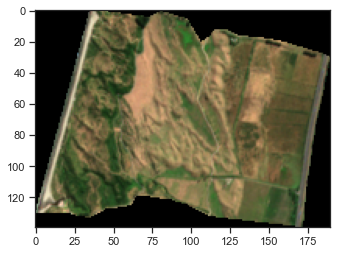

In [65]:
plt.imshow(rgb_bands_orig_norm)

### Section 7. Plotting the PCA-Transformed Data

Make an RGB image of the first three principal components

In [66]:
Princomp_RGB_norm = (PCA_mat[:,:,0:3] - np.min(PCA_mat[:,:,0:3])) /( np.max(PCA_mat[:,:,0:3]) - np.min(PCA_mat[:,:,0:3]))
Princomp_RGB_norm.shape


(140, 190, 3)

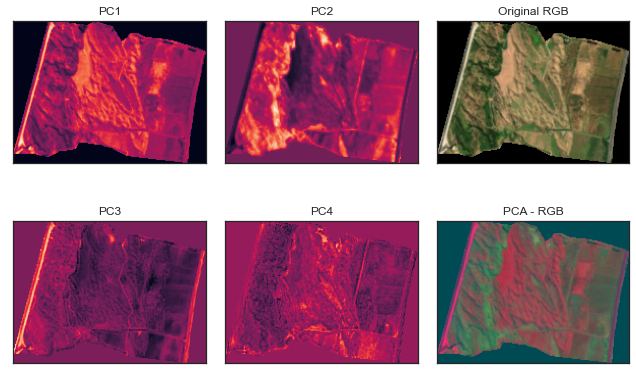

In [67]:

#set up a 2 row x 3 column subplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

# assign an image to each panel
axs[0,0].imshow(PCA_mat[:,:,0])
axs[0,1].imshow(PCA_mat[:,:,1])
axs[0,2].imshow(rgb_bands_orig_norm)
axs[1,0].imshow(PCA_mat[:,:,2])
axs[1,1].imshow(PCA_mat[:,:,3])
axs[1,2].imshow(Princomp_RGB_norm)

#label each panel
axs[0,0].title.set_text('PC1')
axs[0,1].title.set_text('PC2')
axs[0,2].title.set_text('Original RGB')
axs[1,0].title.set_text('PC3')
axs[1,1].title.set_text('PC4')
axs[1,2].title.set_text('PCA - RGB')

# squish the panels together
plt.tight_layout()

# write the plot to a file 
PCA_panelplot_filename = 'PCA_panelplot.png'
PCA_panelplot_full_filename = os.path.join(work_folder, PCA_panelplot_filename )
plt.savefig(PCA_panelplot_full_filename)


### Section 8. Getting raster data from Python Back to Envi

Ok now lets get the principal component image back into a format that can be read by ENVI. First, since we are going to be creating a spatial object (an ENVI file in this case) we need to provide a bunch of meta data (eg filetype, datatype, CRS etc). We read a lot of that information in when we first read the file into the object src. The object src contains an attribute called "profile" that contains a lot of that information. We can copy most of that information from crc

In [68]:
# copy the profile of the input file
PCA_profile = src.profile

#have a look at it
print(PCA_profile)



{'driver': 'ENVI', 'dtype': 'uint16', 'nodata': 0.0, 'width': 190, 'height': 140, 'count': 10, 'crs': CRS.from_epsg(32760), 'transform': Affine(10.0, -0.0, 328980.0,
       -0.0, -10.0, 5465380.0), 'tiled': False, 'interleave': 'band'}


all looks good now but we only have 5 bands now so lets update the PCA_profile to reflect that and also change the data type to 8bytes to save space

In [69]:
PCA_profile.update(
        dtype=rio.uint8,
        count=5,
        compress='lzw')
    
print(PCA_profile)

{'driver': 'ENVI', 'dtype': 'uint8', 'nodata': 0.0, 'width': 190, 'height': 140, 'count': 5, 'crs': CRS.from_epsg(32760), 'transform': Affine(10.0, -0.0, 328980.0,
       -0.0, -10.0, 5465380.0), 'tiled': False, 'interleave': 'band', 'compress': 'lzw'}


In [70]:
PCA_image_filename = 'PCA_image.dat'
PCA_image_full_filename = os.path.join(work_folder, PCA_image_filename )

#reshape PCA_mat from mnp to pmn
PCA_pmn = np.moveaxis(PCA_mat,-1,0)
print(PCA_pmn.shape)


with rio.open(PCA_image_full_filename, 'w', **PCA_profile) as dst:
        dst.write(PCA_pmn.astype(rio.uint8))

(5, 140, 190)



Ok now see if you can open the PCA image in ENVI

### 9. Do some band maths in Python to calculate NDVI

You would have noted that by far the greatest source of variation was PC1, in which the weightings were evenly distributed across all the bands. Much of the information in the image is to do with variations in surface boradband albedo (reflectance). So quite often we want to normalise for this effect. This is the denominator in an index like NDVI, where the denominator is the total amount of reflectance in the Red and Near-IR. Lets calculate NDVI in this.

(140, 190)
(140, 190)
0.5625 -0.0464
1.0 0.0


C:\Users\User\anaconda3\envs\gisc424\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\User\anaconda3\envs\gisc424\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


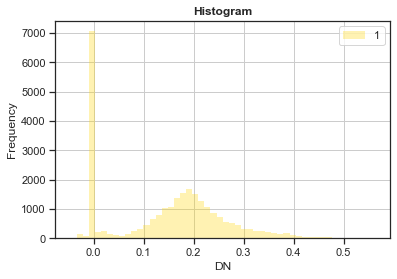

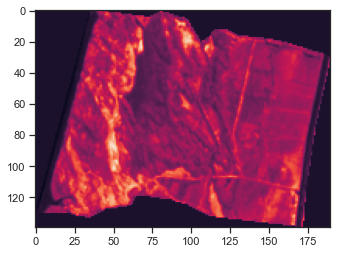

In [71]:
#Red in the image is Band 9, #NIR in the iamge is Band 10. We access them in the array with indices 8 and 9, respectively



RED = arr[8,:]/1e4
NIR = arr[9,:]/1e4




print(RED.shape)
print(NIR.shape)




NDVI = np.divide(   (NIR-RED), (NIR+RED)  )

NDVI =  (NIR-RED)/ (NIR+RED)


NDVI = NIR-RED
NDVI_norm = np.divide(  (NDVI - np.nanmin(NDVI)),(np.nanmax(NDVI)- np.nanmin(NDVI))  )

print(np.nanmax(NDVI), np.nanmin(NDVI))

NDVI_norm[np.isnan(NDVI_norm)] = 0
print(np.nanmax(NDVI_norm), np.nanmin(NDVI_norm))

np.histogram(NDVI)


from rasterio.plot import show_hist
show_hist(
     NDVI, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")





plt.imshow(NDVI)


Now lets save this file as an ENVI File and look at it in ENVI

NDVI_exp = np.expand_dims(NDVI,0)


NDVI_profile = src.profile

NDVI_profile.update(
        dtype=rio.float64,
        count=1)
print(NDVI_profile)

NDVI_image_filename = 'NDVI_image_float.dat'
NDVI_image_full_filename = os.path.join(work_folder, NDVI_image_filename )

with rio.open(NDVI_image_full_filename, 'w', **NDVI_profile) as dst:
        dst.write( (NDVI_exp))

# GISC424 Lab3 – Image Transformations


- Jupyter Notebook that will read the PostFireLayerStack.dat layer
- Envi Burn Indices Tutorial

C:\Users\User\anaconda3\envs\gisc424\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
C:\Users\User\anaconda3\envs\gisc424\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\envs\gisc424\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


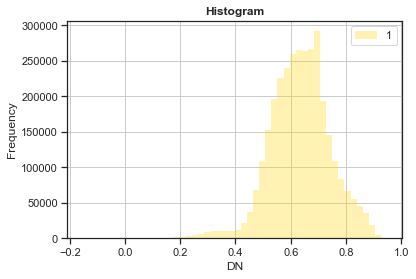

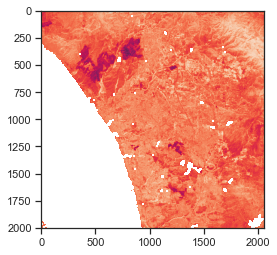

In [72]:
# specify the folder and the file
work_folder = r'C:\Users\User\Desktop\Remote Sensing GISC424\lab_3_remote_sen'
NBR_Therm_image_filename = 'PostFireLayerStack.dat'

#join these together to get the full path
ffin = os.path.join(work_folder, NBR_Therm_image_filename)

#make sure the path exists
os.path.exists(ffin)

#open the file with rasterio. We read the information from this file into an "object" called "src"
src = rio.open(ffin)

# read the opened file intoPostFireLayerStack.dat an array
arr = src.read()

# the Normalized Burn Ratio (Thermal) can be calculated by shortwave-infrared (SWIR), near-infrared (NIR) and Thermal Infrared (TIR); bands 6,4,8 

SWIR = arr[6,:]
NIR = arr[4,:]
TIR= arr[8,:]/1000


# Normalized Burn Ratio (Thermal) formular 

NBR_Therm =  ((NIR - SWIR * TIR)/ (NIR + SWIR * TIR ))


# Histogram and imagery plot

from rasterio.plot import show_hist
show_hist(
     NBR_Therm, bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram")

plt.imshow(NBR_Therm)


In [73]:
# Save created file as an ENVI File

NBR_Therm_exp = np.expand_dims(NBR_Therm,0)


NBR_Therm_profile = src.profile

NBR_Therm_profile.update(
        dtype=rio.float32,
        count=1)
print(NBR_Therm_profile)

NBR_Therm_image_filename = 'NBR_Therm_image_float.dat'
NBR_Therm_image_full_filename = os.path.join(work_folder, NBR_Therm_image_filename )

with rio.open(NBR_Therm_image_full_filename, 'w', **NBR_Therm_profile) as dst:
        dst.write( (NBR_Therm_exp))

{'driver': 'ENVI', 'dtype': 'float32', 'nodata': 0.0, 'width': 2057, 'height': 2005, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, -0.0, 448395.0,
       -0.0, -30.0, 3701625.0), 'tiled': False, 'interleave': 'band'}
